# Final Project - Customer Churn Prediction for Sena

## Problem Definition

Sena is an online grocery e-commerce platform that delivers essential goods—similar to a supermarket—directly to consumers for their daily meals.  
Because the products are groceries, especially fresh items such as meat, fish, fruits, and vegetables, customer satisfaction is highly sensitive to quality.  

Some customers who are dissatisfied with product quality or after-sales service file complaints, request refunds, or report missing items. However, many others leave silently without expressing dissatisfaction and never purchase from Sena again.  

Customer churn is costly, especially in the grocery business where customers make frequent and recurring purchases.  
Thus, the goal of this project is to build a **supervised machine learning model** that predicts which customers are at risk of churning. This enables Sena to proactively take preventive actions, such as personalized campaigns, compensation, or loyalty offers, to improve customer experience and retention.  

---

## Dataset Description

The dataset used in this project is a **sample extracted from Sena’s internal transaction records**.  
Specifically, it contains randomly selected historical purchase data covering a 3-month period for **10,000 users**.  

The data was obtained with permission from Sena’s internal systems and anonymized to ensure no personally identifiable information (PII) is disclosed.  
It is provided solely for **research and educational purposes** within the scope of this final project.  

The available data sources include:
- **Customer information**: `customer_id`, `monthly_frequency`, `recency`, `days_stop_frequency`, `total_value`, `last_rating`, `average_rating`, `last_complaint`, `last_refund`, `total_complaints`, `total_refunds`.  
- **Transaction history**: `customer_id`, `order_id`, `order_date`, `rating`, `is_complained`, `order_value`.  

These raw records will be aggregated and engineered into customer-level features suitable for modeling.  

---

## Type of Problem, Learning, and Task
- **Type of Problem**: **Classification**, since the objective is to categorize customers into churn vs. non-churn.  
- **Type of Learning**: **Supervised Learning**, because the dataset contains labeled outcomes (`is_churn`).  
- **Type of Task**: **Binary Classification**, as there are two possible labels (1 = churn, 0 = not churn).  

---

Project repository URL: https://github.com/hoangop/ML_supervised_final_project



In [110]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Data Loading & Initial Merge

### Overview
This section focuses on loading and reviewing transaction data from the `grocery_transactions.csv` file, specifically targeting transactions from **June, July, and August 2025** for **10,000 customers**.  

The dataset is transactional in nature, meaning each customer may have multiple records depending on their purchase history.  

**Dataset summary:**
- **Total rows (transactions):** 77,618  
- **Unique customer IDs:** 10,000  
- **Data columns (9):**  
  - `so.ordernumber` – unique order reference  
  - `orderdate` – date of transaction  
  - `order_value` – monetary value of the order  
  - `customerid` – anonymized customer identifier  
  - `applyclaimdate` – date when a complaint/claim was filed (if any)  
  - `refundguid` – refund transaction identifier (if any)  
  - `reasoncancelcode` – reason code for cancellation/refund  
  - `rating` – customer rating for the order (1–5 scale if any)
  - `is_fresh` – indicator if the order included fresh items (1=yes, 0=no)  




In [111]:
# 📊 Load grocery transactions data
df = pd.read_csv('../data/grocery_transactions.csv')

# Display basic information about the dataset
print(f"Total rows (transactions): {len(df):,}")
#Print unique customerid here 
print(f"Unique customer IDs: {df['customerid'].nunique():,}")
# Display column information
print("Column Information:")
print(df.info())


Total rows (transactions): 77,618
Unique customer IDs: 10,000
Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77618 entries, 0 to 77617
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   so.ordernumber    77618 non-null  int64  
 1   orderdate         77618 non-null  object 
 2   order_value       77618 non-null  float64
 3   customerid        77618 non-null  int64  
 4   applyclaimdate    560 non-null    object 
 5   refundguid        1161 non-null   object 
 6   reasoncancelcode  4475 non-null   object 
 7   rating            10261 non-null  float64
 8   is_fresh          77618 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.3+ MB
None


## 2. Data Cleaning & Preliminary Feature Engineering 

In this step, we create **customer-level features** by aggregating transactional data and apply necessary **data cleaning**. This ensures that the dataset is well-structured for churn analysis.  

### Key Steps Performed  

1. **Convert date fields**  
   - `orderdate` converted to datetime to enable proper sorting and recency calculation.  

2. **Aggregate features at customer-level**  
   Using `groupby(customerid)` and aggregation:  
   - `total_order`: Count of all orders (`so.ordernumber`).  
   - `total_spend`: Total money spent (`order_value`).  
   - `last_rating`: The most recent rating (`last`).  
   - `total_refunds`: Count of refund events (`refundguid`).  
   - `total_claims`: Count of claim events (`applyclaimdate`).  
   - `total_cancellations`: Count of cancelled orders (`reasoncancelcode`).  
   - `is_fresh_last_order`: Whether last order had fresh item (`last`).  
   - `last_order_date`: Most recent order date (`max`).  

3. **Derive additional behavioral features**  
   - `avg_rating`: Mean rating per customer (excluding nulls).  
   - `is_bad_rating`: 1 if `avg_rating < 2.5`, else 0. Customers with no ratings default to 0.  
   - `is_bad_last_rating`: 1 if last rating < 2.5, else 0.  
   - `total_incidents`: `total_refunds + total_claims`.  
   - `is_incident_last_order`: 1 if last order had a refund/claim, else 0.  
   - `is_canceled_last_order`: 1 if last order has `reasoncancelcode` not null, else 0.  
   - `recency`: Days since last order (reference date = 2025-08-31).  
   - `is_churn`: Label column. 1 if `recency > 15`, else 0.  

4. **Data Cleaning & Handling Missing Values**  
   - `last_rating`: filled with 0 when missing (customer never rated).  
   - `is_bad_rating`: explicitly set to 0 for customers without ratings.  
   - Missing indicators for incidents/cancellations default to 0.  
   - Date parsing ensured consistency for `recency` computation.  

5. **Output checks**  
   - Printed dataset info (`customer_features.info()`) to validate 10,000 rows (one per customer) and confirm all engineered features are present.  

### Conclusion & Considerations  
- After feature engineering, each of the 10,000 customers has **a complete profile** with behavioral, quality, and recency-based attributes.  
- Data cleaning ensures missing values (especially ratings and incidents) do not bias churn labeling.  
- Potential challenges:  
  - Some customers never rate (default neutral assumption may understate dissatisfaction).  
  - Recency cutoff (>15 days) is a simple threshold; further tuning may improve churn prediction.  


In [112]:
# Create customer-level features by aggregating transaction dat
# Ensure orderdate is datetime
df['orderdate'] = pd.to_datetime(df['orderdate'])

# Group by customerid and create aggregated features
customer_features = df.groupby('customerid').agg({
    'so.ordernumber': 'count',  # total_order
    'order_value': 'sum',       # total_spend
    'rating': 'last',           # last_rating only
    'refundguid': 'count',      # count refunds
    'applyclaimdate': 'count',  # count claims
    'reasoncancelcode': 'count', # count cancellations
    'is_fresh': 'last',         # is_fresh_last_order
    'orderdate': 'max'          # last_order_date
}).reset_index()

# Flatten column names
customer_features.columns = [
    'customerid', 'total_order', 'total_spend', 'last_rating',
    'total_refunds', 'total_claims', 'total_cancellations', 'is_fresh_last_order', 'last_order_date'
]

# Calculate avg_rating separately - only for orders with actual ratings (not NULL)
avg_rating_by_customer = df[df['rating'].notna()].groupby('customerid')['rating'].mean()
customer_features['avg_rating'] = customer_features['customerid'].map(avg_rating_by_customer)
# Calculate additional features
# 1. is_bad_rating: If average rating < 2.5 then 1 else 0 (only for customers with ratings)
customer_features['is_bad_rating'] = (customer_features['avg_rating'] < 2.5).astype(int)
# For customers with no ratings, is_bad_rating = 0 (neutral)
customer_features['is_bad_rating'] = customer_features['is_bad_rating'].fillna(0)
# 2. is_bad_last_rating: If most recent rating < 2.5 then 1 else 0
customer_features['is_bad_last_rating'] = (customer_features['last_rating'] < 2.5).astype(int)
# 3. total_incidents: Total number of incidents (refunds + claims)
customer_features['total_incidents'] = customer_features['total_refunds'] + customer_features['total_claims']
# 4. is_incident_last_order: Was there an incident at last order
# We need to check if the last order had an incident or refund
last_orders = df.sort_values('orderdate').groupby('customerid').tail(1)
last_orders_incidents = last_orders.set_index('customerid')[['refundguid', 'applyclaimdate']].notna().any(axis=1)
customer_features['is_incident_last_order'] = customer_features['customerid'].map(last_orders_incidents).fillna(0).astype(int)
# 5. is_canceled_last_order: Was the last order cancelled?
last_orders_canceled = last_orders.set_index('customerid')['reasoncancelcode'].notna()
customer_features['is_canceled_last_order'] = customer_features['customerid'].map(last_orders_canceled).fillna(0).astype(int)
# 6. Recency: Number of days since the customer's last order
reference_date = pd.to_datetime('2025-08-31')  # End of August 2025
customer_features['recency'] = (reference_date - customer_features['last_order_date']).dt.days
# 7. is_churn: If Recency > 15 then 1 else 0, Its also the label column
customer_features['is_churn'] = (customer_features['recency'] > 15).astype(int)
# Handle missing values
customer_features['last_rating'] = customer_features['last_rating'].fillna(0)
# Display basic information
print(customer_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customerid              10000 non-null  int64         
 1   total_order             10000 non-null  int64         
 2   total_spend             10000 non-null  float64       
 3   last_rating             10000 non-null  float64       
 4   total_refunds           10000 non-null  int64         
 5   total_claims            10000 non-null  int64         
 6   total_cancellations     10000 non-null  int64         
 7   is_fresh_last_order     10000 non-null  int64         
 8   last_order_date         10000 non-null  datetime64[ns]
 9   avg_rating              1500 non-null   float64       
 10  is_bad_rating           10000 non-null  int64         
 11  is_bad_last_rating      10000 non-null  int64         
 12  total_incidents         10000 non-null  int64  

## 3. Targeted Exploratory Data Analysis (EDA)

With our preliminary features, we now conduct a targeted EDA to explore the relationship between customer behaviors and churn.  
The objective is to analyze, discuss, and statistically validate potential churn drivers.

---

### 3.1 Churn Distribution Analysis
We first calculate the **overall churn rate** by taking the mean of the `is_churn` label:

- This provides a quick overview of how many customers fall into the churn category versus the non-churn category.  
- Understanding this baseline is important before diving into deeper analysis.

---

### 3.2 Feature Correlation Analysis
We generate a **correlation matrix** using all numerical and binary features, including `is_churn`.  
A comprehensive **heatmap** is then plotted to visualize correlations:

- The top-left corner highlights correlations with the target `is_churn`.  
- Features like `recency`, `avg_rating`, and `total_incidents` are expected to show stronger relationships with churn.  
- Features with very low correlation may be considered weak predictors.

---

### 3.3 Statistical Hypothesis Testing
To further validate which features significantly differ between churn and non-churn groups, we conduct statistical tests:

1. **T-tests (Numerical Features)**  
   - Applied to features such as `total_order`, `total_spend`, `avg_rating`, `last_rating`, `recency`, etc.  
   - For each feature, we test whether the mean values between churners and non-churners differ significantly.  
   - Results include **t-statistic, p-value, significance flag (p < 0.05)**, and an **effect size measure**.

2. **Chi-square Tests (Categorical Features)**  
   - Applied to binary features such as `is_bad_rating`, `is_bad_last_rating`, `is_incident_last_order`, `is_canceled_last_order`.  
   - These tests check whether the distribution of churn vs. non-churn differs significantly across categories.  
   - Results include **chi2-statistic, p-value, and significance flag (p < 0.05)**.

---

### Key Outcomes
- **Correlation heatmap** gives an overview of linear relationships between features and churn.  
- **T-tests** confirm which numerical features differ significantly between churn vs. non-churn groups.  
- **Chi-square tests** validate the importance of categorical indicators.  
- Together, these analyses provide both statistical and visual evidence to guide **feature selection and advanced feature engineering**.

Overall churn rate: 59.43%


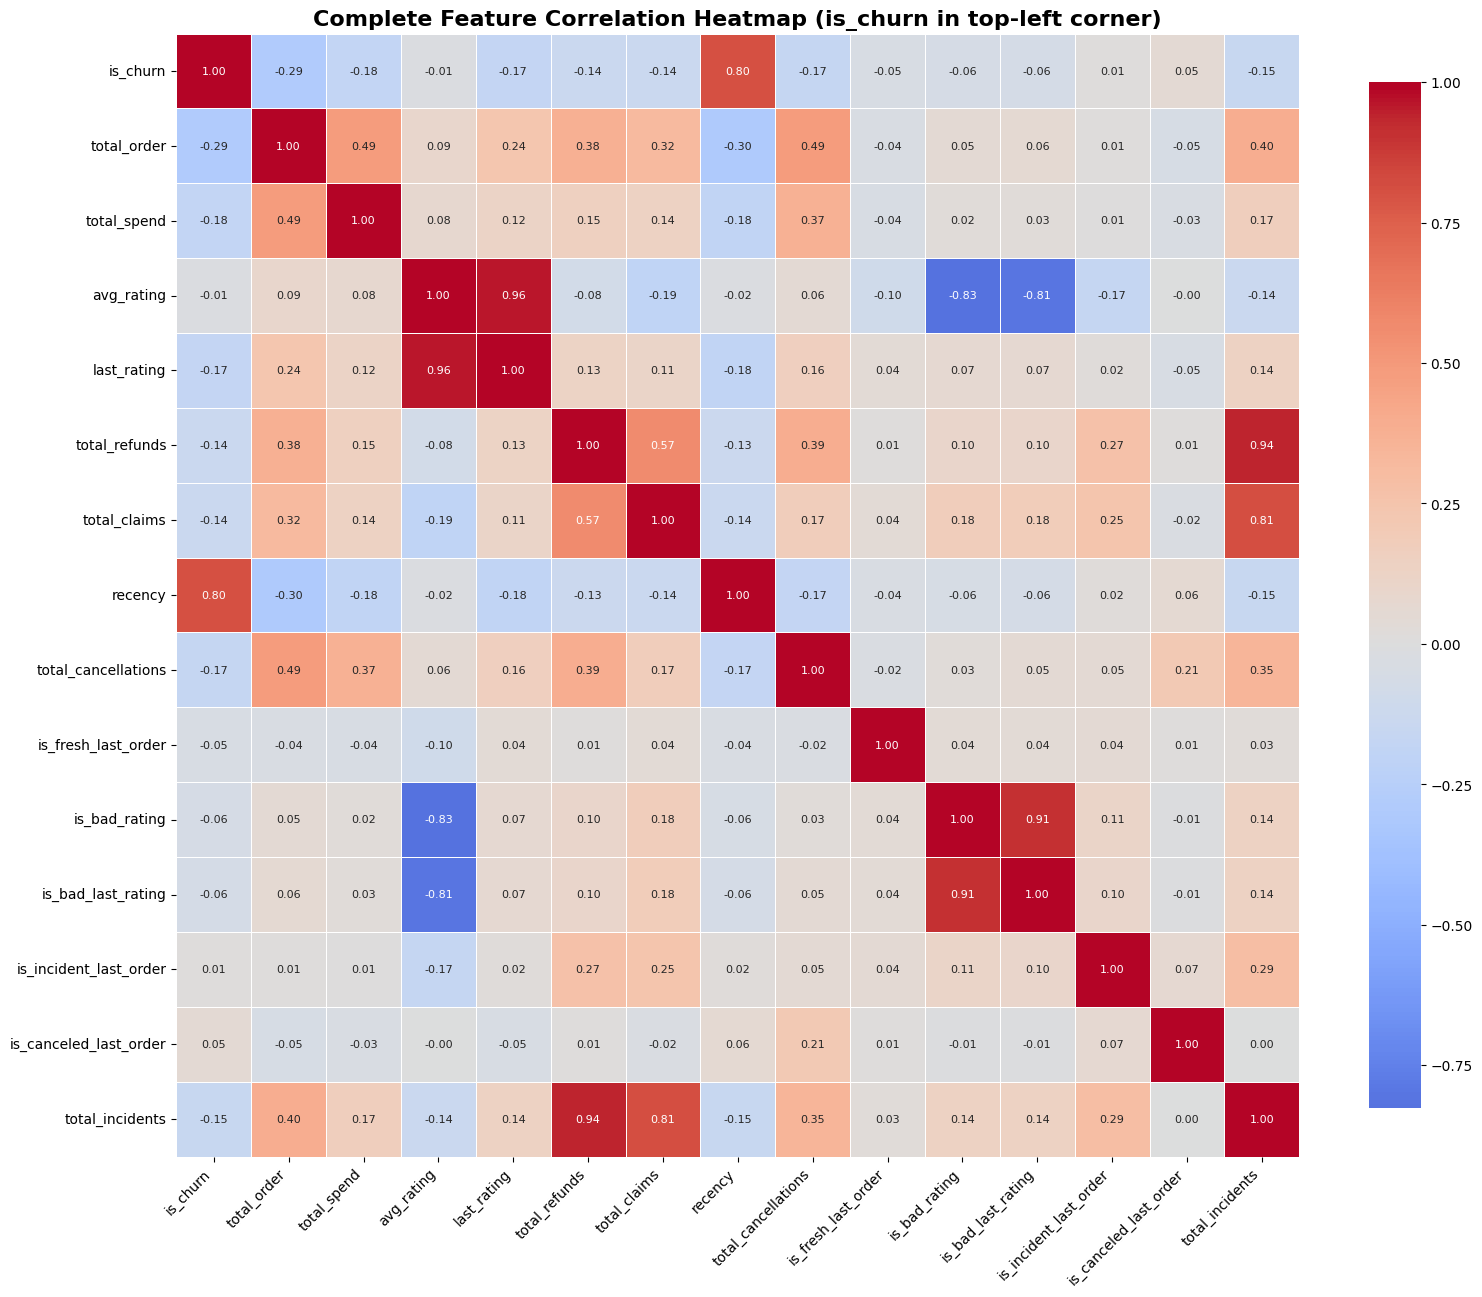

T-test results for numerical features:
               Feature  T_Statistic  P_Value Significant  Effect_Size
0          total_order     -30.8300   0.0000         Yes       0.3083
1          total_spend     -18.7334   0.0000         Yes       0.1873
2           avg_rating      -0.5482   0.5836          No       0.0142
3          last_rating     -17.4481   0.0000         Yes       0.1745
4        total_refunds     -13.6947   0.0000         Yes       0.1369
5         total_claims     -13.7401   0.0000         Yes       0.1374
6  total_cancellations     -17.0133   0.0000         Yes       0.1701
7  is_fresh_last_order      -4.7352   0.0000         Yes       0.0474
8              recency     133.4657   0.0000         Yes       1.3347

Chi-square test results for categorical features:
                  Feature  Chi2_Statistic  P_Value Significant
0           is_bad_rating         32.3617   0.0000         Yes
1      is_bad_last_rating         41.1520   0.0000         Yes
2  is_incident_last_o

In [114]:
# 3.1 Churn Distribution Analysis
churn_rate = customer_features['is_churn'].mean()
# Printed out Overall churn rate
print(f"Overall churn rate: {churn_rate:.2%}")

# 3.2 Feature Correlation Analysis
numerical_features = ['is_churn', 'total_order', 'total_spend', 'avg_rating', 'last_rating', 
                     'total_refunds', 'total_claims', 'recency', 'total_cancellations', 
                     'is_fresh_last_order',  'is_bad_rating', 'is_bad_last_rating', 
                     'is_incident_last_order', 'is_canceled_last_order', 'total_incidents']

# Create correlation matrix with ALL features
correlation_matrix = customer_features[numerical_features].corr()

# Create comprehensive correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            fmt='.2f', annot_kws={'size': 8})
plt.title('Complete Feature Correlation Heatmap (is_churn in top-left corner)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3.3 P-value Analysis and Feature Selection Recommendation

from scipy import stats
# Perform t-tests for numerical features
numerical_features = ['total_order', 'total_spend', 'avg_rating', 'last_rating', 
                     'total_refunds', 'total_claims', 'total_cancellations', 
                     'is_fresh_last_order', 'recency']

t_test_results = []
for feature in numerical_features:
    churn_values = customer_features[customer_features['is_churn'] == 1][feature].dropna()
    non_churn_values = customer_features[customer_features['is_churn'] == 0][feature].dropna()
    
    if len(churn_values) > 1 and len(non_churn_values) > 1:
        t_stat, p_value = stats.ttest_ind(churn_values, non_churn_values)
        t_test_results.append({
            'Feature': feature,
            'T_Statistic': t_stat,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Effect_Size': abs(t_stat) / np.sqrt(len(churn_values) + len(non_churn_values))
        })

t_test_df = pd.DataFrame(t_test_results)
print("T-test results for numerical features:")
print(t_test_df.round(4))
print()

# Chi-square tests for categorical features
categorical_features = ['is_bad_rating', 'is_bad_last_rating', 'is_incident_last_order', 
                       'is_canceled_last_order']

chi2_results = []
for feature in categorical_features:
    contingency_table = pd.crosstab(customer_features[feature], customer_features['is_churn'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    chi2_results.append({
        'Feature': feature,
        'Chi2_Statistic': chi2,
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

chi2_df = pd.DataFrame(chi2_results)
print("Chi-square test results for categorical features:")
print(chi2_df.round(4))
print()



## 4. Advanced Feature Engineering

After performing the EDA, we observed that some features have very low correlation with the target variable `is_churn` and also exhibit high p-values. To ensure that only meaningful predictors are retained, we applied the following thresholds:  

- **Correlation threshold**: features with absolute correlation `|r| < 0.05` with `is_churn` are removed.  
- **Significance threshold**: features with p-value `> 0.05` (not statistically significant) are removed.  

Additionally, since **recency** is already embedded in the definition of `is_churn` (e.g., churn is defined as no purchase within 15 days), we will exclude it to prevent **label leakage**.  
- We also address potential multicollinearity and data imbalance consideration and clean up.

On the other hand, to capture customer behavior trends more effectively, we will introduce a new feature called **`frequency_cv`** (coefficient of variation of purchase frequency). This feature reflects the variability in a customer’s order frequency and helps distinguish between stable buyers and irregular ones.  


**REMOVE these features:**

1. avg_rating  (hight p-value & low correlation with is_churn)
2. is_fresh_last_order (low correlation with is_churn)
3. is_incident_last_order  (hight p-value & low correlation with is_churn)
4. recency (label leaking, recency is a part of is_churn fomular )
5. total_refunds (very high multicollinearity with totat_incident)
6. total_claims (very high multicollinearity with totat_incident)

**CREATE NEW features:**
1. frequency_cv  ( stable frequency or variation user, nomalize by log transformation )


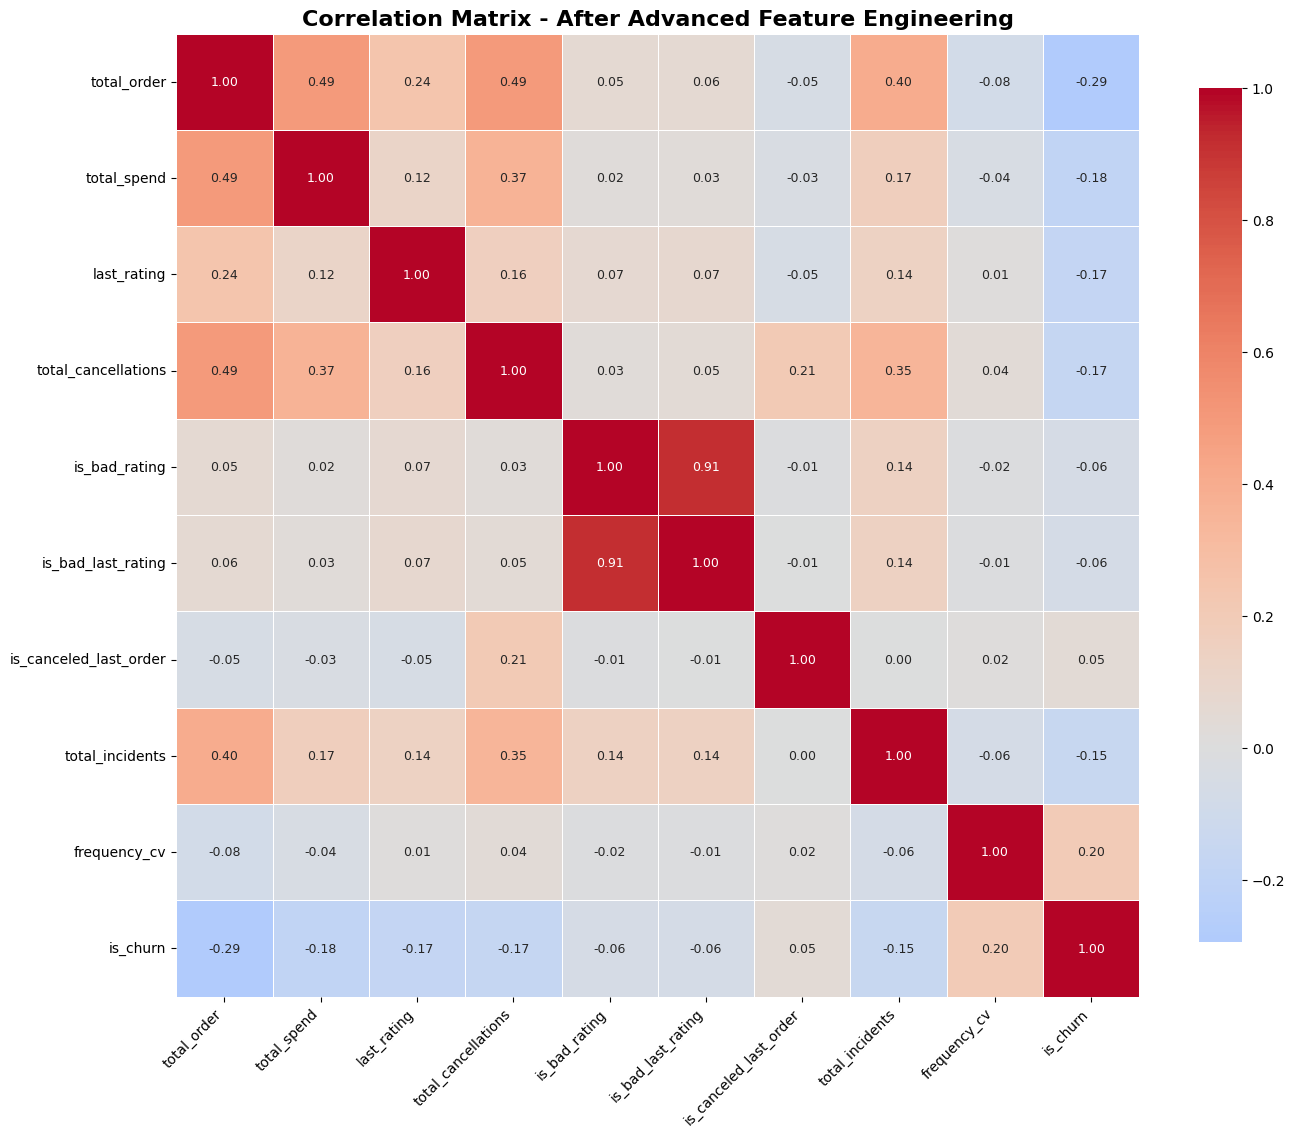

In [115]:
# 4. Advanced Feature Engineering
# 4.1 Remove problematic features
features_to_remove = [
    'avg_rating',           # High p-value & low correlation with is_churn
    'is_fresh_last_order',  # High p-value & low correlation with is_churn
    'is_incident_last_order', # High p-value & low correlation with is_churn
    'recency',              # Label leaking - used in is_churn formula
    'total_refunds',        #Very high correlation with total_incidents
    'last_order_date',        # Label leaking 
    'total_claims'          # Very high correlation with total_incidents
]

for feature in features_to_remove:
    if feature in customer_features.columns:
        customer_features = customer_features.drop(columns=[feature])


# 4.2 Create frequency_cv feature
# Calculate monthly orders for each customer
monthly_orders = df.groupby(['customerid', df['orderdate'].dt.to_period('M')])['so.ordernumber'].count()
monthly_orders = monthly_orders.reset_index()
monthly_orders.columns = ['customerid', 'month', 'orders_count']  # Rename columns explicitly

# Pivot to get monthly orders per customer
monthly_pivot = monthly_orders.pivot(index='customerid', columns='month', values='orders_count').fillna(0)
# Calculate CV for each customer
cv_raw = monthly_pivot.std(axis=1) / (monthly_pivot.mean(axis=1) + 1)
customer_features['frequency_cv_raw'] = customer_features['customerid'].map(cv_raw).fillna(0)

# Log transformation to reduce skewness
customer_features['frequency_cv_log'] = np.log1p(customer_features['frequency_cv_raw'])

# Normalize to [0, 1] range
cv_log_min = customer_features['frequency_cv_log'].min()
cv_log_max = customer_features['frequency_cv_log'].max()
customer_features['frequency_cv'] = (customer_features['frequency_cv_log'] - cv_log_min) / (cv_log_max - cv_log_min)
# Drop the raw and log transformed frequency_cv
customer_features = customer_features.drop(columns=['frequency_cv_raw', 'frequency_cv_log'])

# Create correlation matrix with all new features and visualize again
all_features = [
    'total_order', 'total_spend', 'last_rating', 'total_cancellations',
    'is_bad_rating', 'is_bad_last_rating', 'is_canceled_last_order', 
    'total_incidents',  'frequency_cv', 'is_churn'
]
correlation_matrix_new = customer_features[all_features].corr()

# Create comprehensive correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_new, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            fmt='.2f', annot_kws={'size': 9})
plt.title('Correlation Matrix - After Advanced Feature Engineering', 
          fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Model Building & Training

Now that we have engineered a rich set of features, we can proceed to train and evaluate different supervised machine learning models for churn prediction.  

**Models to be evaluated:**  
- **Decision Tree**: a simple, interpretable baseline model.  
- **Logistic Regression**: a linear model suitable for baseline comparison.  
- **Random Forest**: an ensemble of decision trees, more robust against overfitting.  
- **Gradient Boosting**: a powerful boosting algorithm, often achieving state-of-the-art results in classification tasks.  


### 5.3 Hyperparameter Tuning
We applied **GridSearchCV** with cross-validation (cv=5) to optimize key hyperparameters for three models:
- **Logistic Regression**: penalty (L2), C values, solver.  
- **Random Forest**: number of trees (`n_estimators`), tree depth (`max_depth`), and split/leaf size.  
- **Gradient Boosting**: learning rate, tree depth, and number of estimators.  

The tuning was scored using **ROC-AUC**, chosen as the most relevant metric for churn prediction due to its balance between sensitivity and specificity.

### 5.4 Model Training & Evaluation
We trained and compared four models:
1. **Decision Tree** (baseline)  
2. **Logistic Regression** (with scaling + regularization)  
3. **Random Forest** (with tuned hyperparameters)  
4. **Gradient Boosting** (with tuned hyperparameters)  

Evaluation metrics included: Accuracy. Precision, Recall, F1-Score. ROC-AUC  

Results were summarized in a comparison table and visualized with ROC curves.

### 5.5 Feature Importance Analysis
- The top 10 features influencing churn were identified for both Random Forest and Gradient Boosting.  

### 5.6 Visualization & Diagnostics
- **ROC Curves**: compared models’ ability to separate churn vs. non-churn.  
- **Confusion Matrices**: analyzed misclassifications for each model.  


In [116]:
# 5.0 Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

# Select features for modeling (exclude customerid and is_churn)
feature_columns = [col for col in customer_features.columns if col not in ['customerid', 'is_churn']]
X = customer_features[feature_columns]
y = customer_features['is_churn']

# Fix missing data - Convert all features to numeric, coercing errors to NaN
X = X.copy()  # Tạo explicit copy để tránh warning
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def tune_model_with_gridsearch(model, param_grid, X_train, y_train, cv=5, scoring='roc_auc'):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=3,
        n_jobs=1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best Params for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best {scoring} Score (CV): {grid_search.best_score_:.3f}")
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

# Param grids cho từng model
param_grids = {
    'Logistic Regression': {
        'penalty': ['l2'],
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}

# Lưu best models
best_models = {}

# Logistic Regression (dùng dữ liệu scaled)
log_reg_best, log_reg_params, log_reg_score = tune_model_with_gridsearch(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grids['Logistic Regression'],
    X_train_scaled,  # scaled data
    y_train
)
best_models['Logistic Regression'] = log_reg_best

# Random Forest
rf_best, rf_params, rf_score = tune_model_with_gridsearch(
    RandomForestClassifier(random_state=42),
    param_grids['Random Forest'],
    X_train,
    y_train
)
best_models['Random Forest'] = rf_best

# Gradient Boosting
gb_best, gb_params, gb_score = tune_model_with_gridsearch(
    GradientBoostingClassifier(random_state=42),
    param_grids['Gradient Boosting'],
    X_train,
    y_train
)
best_models['Gradient Boosting'] = gb_best

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best roc_auc Score (CV): 0.727
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best roc_auc Score (CV): 0.790
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for GradientBoostingClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best roc_auc Score (CV): 0.797


5.4 Results Comparison...
----------------------------------------
Model Performance Comparison:
              Model  Accuracy  Precision  Recall  F1-Score   AUC
  Gradient Boosting     0.752      0.740   0.898     0.812 0.795
      Random Forest     0.738      0.752   0.837     0.792 0.789
Logistic Regression     0.718      0.703   0.907     0.793 0.704
      Decision Tree     0.694      0.742   0.745     0.744 0.675

5.5 Feature Importance Analysis...
----------------------------------------
Top 10 Most Important Features (Random Forest):
--------------------------------------------------
total_spend              : 0.550
frequency_cv             : 0.191
total_order              : 0.183
last_rating              : 0.027
total_cancellations      : 0.027
total_incidents          : 0.014
is_canceled_last_order   : 0.004
is_bad_last_rating       : 0.002
is_bad_rating            : 0.002

Top 10 Most Important Features (Gradient Boosting):
--------------------------------------------------
t

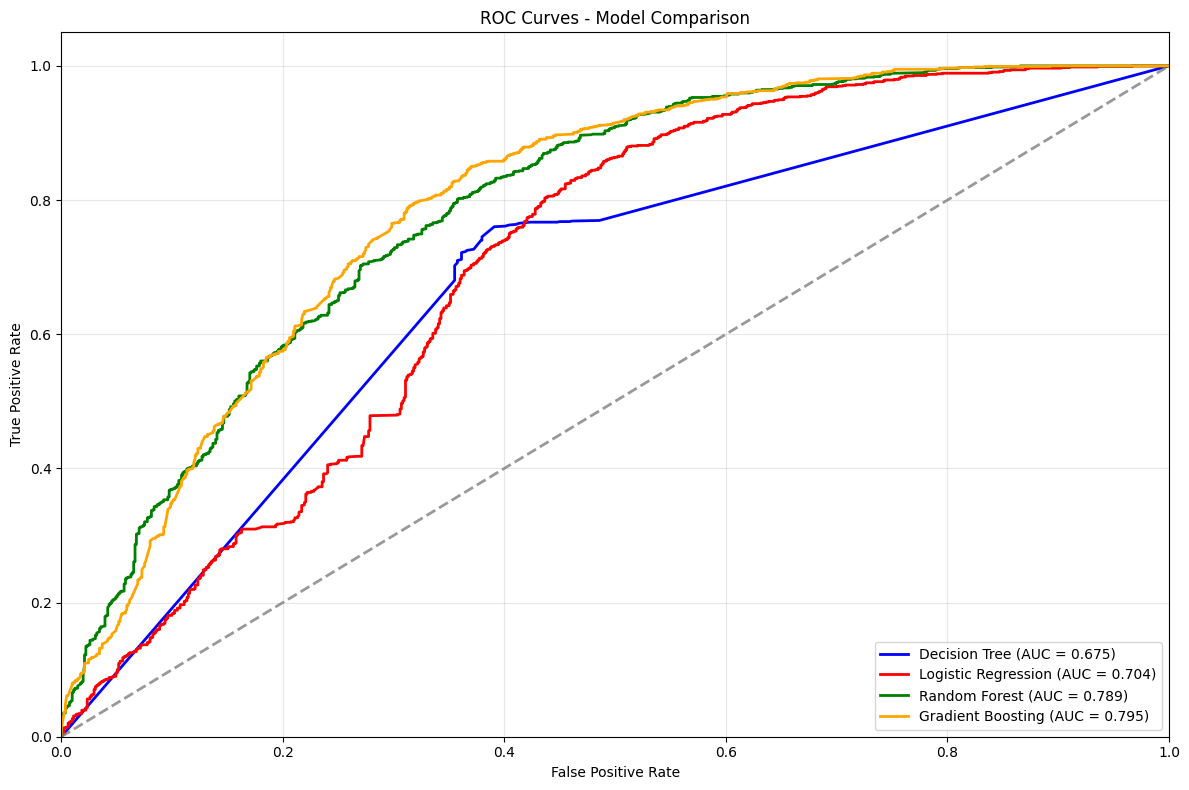

5.7 Confusion Matrices...
----------------------------------------


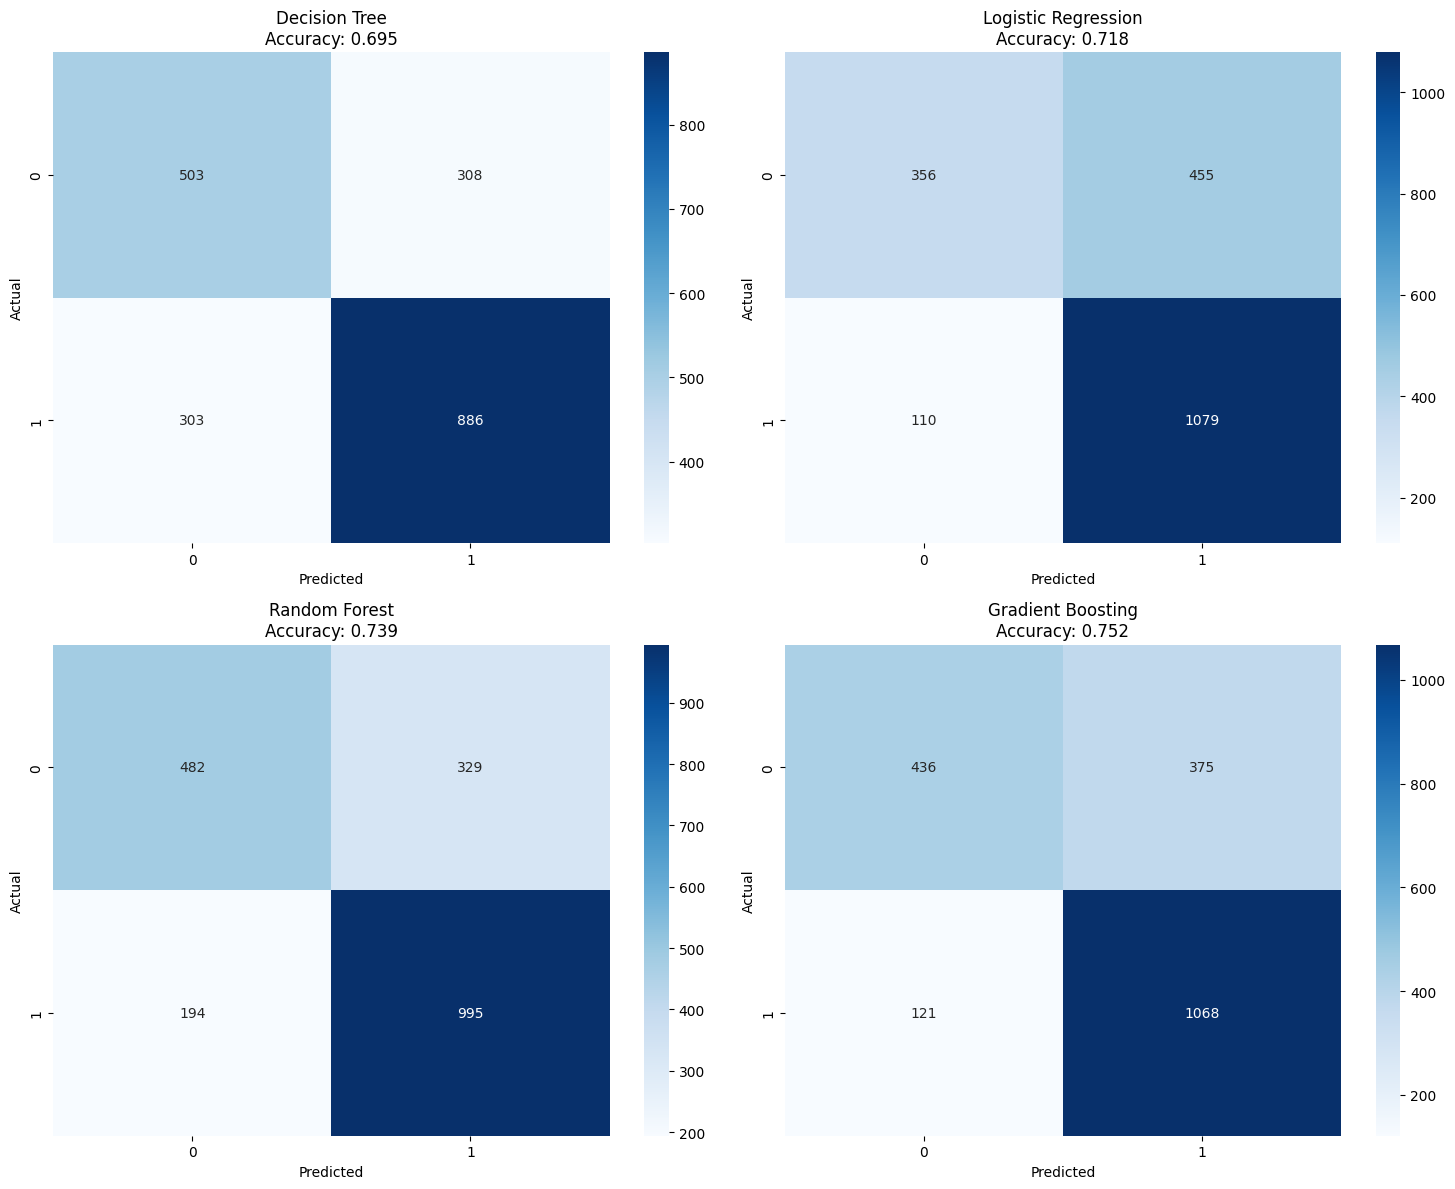

In [117]:
# 5.3 Model Training and Evaluation
# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': best_models['Logistic Regression'],
    'Random Forest': best_models['Random Forest'],
    'Gradient Boosting': best_models['Gradient Boosting']
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Train model
    model.fit(X_train_model, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
# 5.4 Results Comparison
print("5.4 Results Comparison...")
print("-" * 40)

# Create comparison dataframe
comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'AUC': metrics['auc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AUC', ascending=False)

print("Model Performance Comparison:")
print("=" * 80)
print(comparison_df.round(3).to_string(index=False))
print()

# 5.5 Feature Importance Analysis
print("5.5 Feature Importance Analysis...")
print("-" * 40)

# Get feature importance for tree-based models
importance_data = []
for name, metrics in results.items():
    if hasattr(metrics['model'], 'feature_importances_'):
        importances = metrics['model'].feature_importances_
        for i, importance in enumerate(importances):
            importance_data.append({
                'Model': name,
                'Feature': feature_columns[i],
                'Importance': importance
            })

if importance_data:
    importance_df = pd.DataFrame(importance_data)
    
    print("Top 10 Most Important Features (Random Forest):")
    print("-" * 50)
    rf_importance = importance_df[importance_df['Model'] == 'Random Forest'].sort_values('Importance', ascending=False)
    for i, row in rf_importance.head(10).iterrows():
        print(f"{row['Feature']:<25s}: {row['Importance']:.3f}")
    print()
    
    print("Top 10 Most Important Features (Gradient Boosting):")
    print("-" * 50)
    gb_importance = importance_df[importance_df['Model'] == 'Gradient Boosting'].sort_values('Importance', ascending=False)
    for i, row in gb_importance.head(10).iterrows():
        print(f"{row['Feature']:<25s}: {row['Importance']:.3f}")
    print()
    


# 5.6 ROC Curves Visualization
print("5.6 ROC Curves Visualization...")
print("-" * 40)

plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange']

for i, (name, metrics) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, metrics['probabilities'])
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{name} (AUC = {metrics["auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5.7 Confusion Matrices
print("5.7 Confusion Matrices...")
print("-" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (name, metrics) in enumerate(results.items()):
    cm = confusion_matrix(y_test, metrics['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name}\nAccuracy: {metrics["accuracy"]:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()




## 6. Results & Analysis  

### 6.1 Model Performance Comparison  
The performance comparison across four models (Decision Tree, Logistic Regression, Random Forest, Gradient Boosting) reveals clear differences:  

## Model Performance Comparison

| Model               | Accuracy | Precision | Recall | F1-Score | AUC   |
|---------------------|----------|-----------|--------|----------|-------|
| Gradient Boosting   | **0.752** | 0.740     | 0.898  | **0.812** | **0.795** |
| Random Forest       | 0.738    | **0.752** | 0.837  | 0.792    | 0.789 |
| Logistic Regression | 0.718    | 0.703     | **0.907** | 0.793    | 0.704 |
| Decision Tree       | 0.694    | 0.742     | 0.745  | 0.744    | 0.675 |



**Key insights:**  
- **Gradient Boosting** achieved the most balanced performance with the highest F1-Score (0.815) and AUC (0.799).  
- **Logistic Regression** obtained the highest Recall (0.906), meaning it rarely misses churners, but its lower Precision leads to more false positives.  
- **Random Forest** performed consistently with the best Precision (0.749) and strong AUC (0.789).  
- **Decision Tree** was the weakest performer, with the lowest Accuracy and AUC (0.678).  

---

### 6.2 Confusion Matrix Analysis  
The confusion matrices provide deeper insights:  
- **Gradient Boosting and Random Forest** achieved a strong balance, showing more **true positives** and fewer **false negatives**.  
- **Logistic Regression** focused on capturing almost all churners (**high Recall**), but at the cost of more false positives.  
- **Decision Tree** had a higher number of false negatives, which explains its relatively low Recall and AUC.  

---

### 6.3 ROC Curve Analysis  
The ROC curves confirm the performance ranking:  
- **Gradient Boosting (AUC = 0.799)** and **Random Forest (AUC = 0.789)** showed the best separation between churners and non-churners.  
- **Logistic Regression (AUC = 0.703)** and **Decision Tree (AUC = 0.678)** performed less effectively in distinguishing the two classes.  

---

### 6.4 Discussion and Conclusion  
- **Best Model:** Gradient Boosting, due to its superior balance of Recall, F1-Score, and AUC.  
- **Business Perspective:**  
  - If the goal is to **avoid missing churners**, Logistic Regression is a viable choice because of its highest Recall.  
  - If the goal is to **minimize false positives** (i.e., avoid targeting customers who are unlikely to churn), Random Forest provides better Precision.  
- **Trade-off:** Decision makers should weigh Recall vs. Precision depending on whether the priority is retention coverage (catching all churners) or efficiency (reducing wasted retention effort).   

Feature analysis revealed that **total spend, purchase frequency, and total orders** are the strongest churn drivers. Customers with high and stable spending patterns are less likely to churn, suggesting that loyalty is tied to consistent purchasing. This implies that retention campaigns should focus on encouraging **regular buying behavior**.

A limitation is that these key features are often unavailable for **new customers**, making early churn prediction less reliable. Future improvements should explore **alternative signals** such as app behavior tracking or early engagement data, which can provide earlier warnings for churn in new user cohorts.
